# **Exercise 1**
étudiants : 
  João Pedro ARAUJO FERREIRA CAMPOS et Fabrício VELLONE




import libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter

# MNIST DATASET

Définition des paramètres

In [4]:
#parameters and hyper parameters
# batch_size_train is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
#N, D_in, H, D_out = 64, 1000, 100, 10
D_in = 28 * 28
H = 100
D_out = 10

num_epochs = 10

learning_rate = 0.01
w_decay = 1e-3
momentum = 0.9

batch_size_train = 64
batch_size_test = 1000

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

On télécharge les données de MNIST:

In [4]:
#moyenne = 0.1307 ; std deviation = 0.3081 ; pour normalisation des données
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



Visualisation des données:

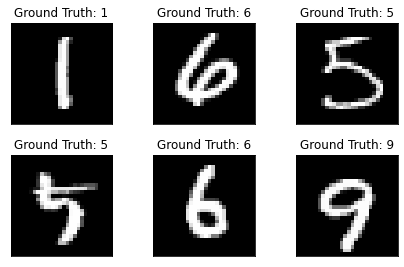

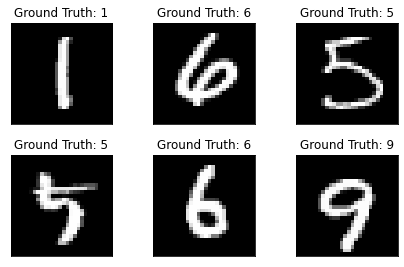

In [5]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

# Simple DNN

Define the simple network :

In [6]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(D_in, H) 
    self.fc2 = nn.Linear(H, D_out) 

  def forward(self, x):
    #flatten
    x = x.view(-1,784)

    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

Initialisation


In [7]:
model = Net()
model = model.to(DEVICE) #pour utiliser GPU (cuda)


Lancer l'optimizer

In [8]:

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay = w_decay, momentum=momentum)

Train the simple net

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.306917
Train Epoch: 0 [6400/60000 (11%)]	Loss: 0.292545
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.617781
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.222362
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.179112
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.093295
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.154275
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.260904
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.264782
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.080932
Epoch 0 average train loss: 0.00442905576856186
Epoch 0 average train accuracy: 0.9161999821662903

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.167023
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.238698
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.106350
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.145684
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.083965
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.088703
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.073235
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.115373
Train Epoch:

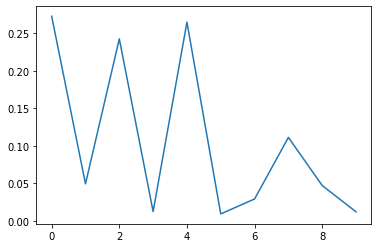

In [9]:
train_losses = []
train_counter = []
writer = SummaryWriter('Res/Simple_net_train')
loss_l = []
for epoch in range(num_epochs):
  average_acc = 0
  average_loss = 0
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(DEVICE), target.to(DEVICE)
    optimizer.zero_grad() #zero the gradient so it doesn't get acumulated
    output = model(data) #forward pass

    #train accuracy
    y_hat = output.data.max(1, keepdim=True)[1]
    train_acc = y_hat.eq(target.data.view_as(y_hat)).sum()
    average_acc += train_acc
    train_acc = train_acc /len(target.data)

    loss = criterion(output, target) #calculates the loss function
    average_loss += loss.item()

    loss.backward() #backward pass (backpropagation)
    optimizer.step() #updates the weights
    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      writer.add_scalar('Loss/train', loss.item(),
                        (epoch - 1) * len(train_loader) + batch_idx)
      writer.add_scalar('Accuracy/train', train_acc,
                        (epoch - 1) * len(train_loader) + batch_idx)
      
  writer.close()
  loss_l.append(loss.item())
  print(f"Epoch {epoch} average train loss: {average_loss / len(train_loader.dataset)}\n" f"Epoch {epoch} average train accuracy: {average_acc / len(train_loader.dataset)}\n")
        
# ----------------
plt.plot(loss_l)

Test the net

In [10]:
test_losses = []
test_loss = 0
correct = 0
with torch.no_grad():
  for data, target in test_loader:
    data, target = data.to(DEVICE), target.to(DEVICE)
    output = model(data)
    test_loss += criterion(output, target)
    pred = output.data.max(1, keepdim=True)[1]
    correct += pred.eq(target.data.view_as(pred)).sum()
test_loss /= len(test_loader.dataset)
test_losses.append(test_loss)
print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
  test_loss, correct, len(test_loader.dataset),
  100. * correct / len(test_loader.dataset)))


Test set: Avg. loss: 0.0001, Accuracy: 9777/10000 (98%)



In [ ]:
interrupt #juste pour interrompre l'execution ici

NameError: ignored

# Convolutional NN

Définition du réseau CNN simple

In [ ]:
class CNN(nn.Module):
    #build the class, 1 channel and 10 classes (B&W images, 10 digits in the MNIST set) 
    def __init__(self, in_channels=1, num_classes=10):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels = 10, kernel_size=5) #2D convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) #fully connected
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Implémentation de ResNet18

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, identity_downsample=None, stride=1):
        
        super(Block, self).__init__()
        self.num_layers = 18

        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x


class ResNet18(nn.Module):
    def __init__(self, block, image_channels, num_classes):

        super(ResNet18, self).__init__()
 
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(block, 2, intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(block, 2, intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(block, 2, intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(block, 2, intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def make_layers(self, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels))
        layers.append(block(self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels  # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)

In [ ]:
def test():
    net = ResNet18(Block, 3, 1000)
    y = net(torch.randn(4, 3, 224, 224)).to(DEVICE)
    print(y.size())
    print(y)

test()



torch.Size([4, 1000])
tensor([[-0.1420, -0.2695,  0.5869,  ..., -0.3288,  0.3506,  0.4209],
        [-0.2983, -0.2310,  0.6669,  ..., -0.3002,  0.6345,  0.5241],
        [-0.2494, -0.1921,  0.5339,  ..., -0.2300,  0.4833,  0.4644],
        [-0.2014, -0.2371,  0.6730,  ..., -0.2191,  0.4419,  0.4853]],
       device='cuda:0', grad_fn=<CopyBackwards>)
